# MLLib Development Notes

Reverse time order - Newest on top

16 August 2022
- A complete parameter weight or flops counter that can be back-propegated contains the relaxed input vector and relaxed output vector
- Torch dynamically computes its network graph
- Torch has nn.Module.children() but not .parnets() so you can walk forward in the network graph 
- Torch backpropegation must walk backwards through the graph
- Can relxation data be passed through network during forward?
- Can relaxation data be passed through the network using "children"
- How to account for diverging input signals like the decoder portion of a U-NET - inputs are received from the pass-through connection and the previous connection?
- Option 1 - include the relaxed vector in in Module.forward(x)
    - This mean a single method of navigating the network
    - Two types of data will be passed as x in the forward call
    - Must explicitly run a forward call before computing loss - this is the standard pattern
    - It looks like this isn't fesible with torch tensors and forward
- Option 2 - Pass the relaxed vector through the graph using nn.Module.children()
    - Need to know initial layer
    - Can walk through layers and pass relaxation functions
    - Requires explicit call and second handling of graph
- Option 3- share weights between modules
- Option 4 - Place the relxation into a seprate module and call it in muliple places
- Torch.Tensor.backward()

12 August 2022
- It looks like parameter sparcity is a poor proxy for model run time on UNET
- FLOPS as objective rather than weights would take into account the image size at each layer
- Parameter sparcity is not taking into account actual compute time
- Results from crisplit_20220811_223202_hiocnn0 and crisplit_20220811_224009_hiocnn0 illustrate 97% parameter sparsity but only 2x speeed increase
- This is explained by flops because the weight for the center & smallest image layers were pruned and weights for the larger layers were retained.




8 August 2022
- Archicture reduction learning_rate 2e-4, k_structure 0.1, k_prune_sigma 1 
- Maintained cross entropy loss and mean intersection/union until final pruning
- Pruning slowed but did not stop as cross entropy loss and MIOU increased.
- Cross entropy loss is the smallest loss: cross_entropy_loss: 0.007638514041900635 architecture_loss: 0.09289148449897766 prune_loss: 0.17779725790023804
- Prune loss impacted and slowed archetecture loss curves
- Failed train-fine due to out of memory error
- Computed pruned size from size in previous step not from origonal size

![crisplit_20220801h00_tb](../img/crisplit_20220801h00_tb_k_structure_01.png)

- Execution order: Train->Prune->Test
- Tests performed after pruning
- Maintained accurcy for the first 2 pruning steps

[normalized-train_cw]: ../img/crisplit_20220801h000_normalized-train_cw.png
[train_cw]: ../img/crisplit_20220801h000_train_cw.png
[ss_00_cw]: ../img/crisplit_20220801h000_search_structure_00_cw.png
[ss_01_cw]: ../img/crisplit_20220801h000_search_structure_01_cw.png
[ss_02_cw]: ../img/crisplit_20220801h000_search_structure_02_cw.png
|  | normalized-train | train | Search 0 | Search 1 | Search 2 |
|:--:|:--:|:--:|:--:|:--:|:--:|
|Cross Entropy Loss|0.2146|0.0046 |0.0054 |0.002837|0.00763|
|MIOU              |      |0.8762 |0.9055 |0.891740|0.85680|
|Reamining Ratio   |1.0   |1.0    |0.0594 |0.033540|0.02967|
| Prune Weights |![][normalized-train_cw]|![][train_cw] |![][ss_00_cw] |![][ss_01_cw]|![][ss_02_cw]|

- Failed to prune effectively: k_structure: 0.05 k_prune_basis: 1.0 
- Failed to prune effectively: k_structure: 0.01 k_prune_basis: 1.0
- Failed to prune effectively: k_structure: 0.01 k_prune_basis: 0.5
- Add  k_accuracy to increase cross entropy loss weight without decreasing k_structure and k_prune_sigma to the point they have a vanishing gradient.

27 July 2022
- Yesterday's training froze at the end of the step "search-structure-01".  There was no error message and the pod was in the executing state
- There were several failed S3 image reads during the run.
- I killed the pod and restarted the run to see if the failure repeats.
- I added ptflops flops counting library to the project
- get_model_complexity_info is called from a few points and printed to stdout
- Investigate the output in the debugger and include the network flops in the model output
- Investigate replacing current model size counter with flops counter for loss computation

26 July 2022
- Implemented multi-step training
- Much faster - 5 days to 10 hours
- Each step is 2x faster because I enable 1 device reading thread
- About the same number of total steps
- Accuracy maintained until final train
- Final step removed sigmoid scaling without compensation
- Initializing sigmoid to 0 and sech not pushing output to 1
- Final train accuracy would likely match other accuracy with additional training
- Infer time did not drop
- Torch passes data to and from GPU on each layer - this will limit infer time
- The batch size remained fixed through training - this will limit infer time

![crisplit_20220723i01_tb](../img/crisplit_20220723i01_tb.png)
![crisplit_20220723i01_tb_time](../img/crisplit_20220723i01_tb_time.png)

- The search strcture image are from the previous step's pruning
- crisplit_20220723i010_search_structure_00 remaining parameters 10288177/31037517 = 0.33147551719423946
- crisplit_20220723i010_search_structure_01 remaining parameters 1749302/10288177 = 0.1700303173244395
- crisplit_20220723i010_search_structure_02 remaining parameters 394959/1749302 = 0.2257809114721186
- Pruned quickly even with k_prune_basis=0.1, k_structure=0.1, convMaskThreshold=0.01
- Rarely push retained class weights to red
- Only cross entropy loss settled
- Architecture loss still dropping
- prune loss still dripping
![train](../img/crisplit_20220723i010_train_cw.png)
![search_structure_00](../img/crisplit_20220723i010_search_structure_00_cw.png)
![search_structure_01](../img/crisplit_20220723i010_search_structure_01_cw.png)
![search_structure_02](../img/crisplit_20220723i010_search_structure_02_cw.png)
![final](../img/crisplit_20220723i010_cw.png)

- Maintain size comparison to initial network size, not previous pruned size
- Push sigmoid output to 1
- If not, compensate for sigmoid scale when pruning
- Dynamically adjust batch size

12 July 2022
- Initialized pruning weight to 0 so architecture loss has maximum gradient and prune loss gradient is small
- Quick convergence of architecture loss
- Slow convergence of prune loss
- Maintained good cross entropy loss throughout optimization 

![Tensorboard](../img/crisplit_20220709i_tb.png)

- There is is a significant blue-shift for the prune_weights plot
- This isn't necessarily a problem because there is a clear separation between the dark blue and other weights

![Class Weights](../img/crisplit_20220709i0_train-fine_cw.png)

- prune_weight moved quickly to blue (off) but not to red(on)
- Setting target_structure to 0 means there is always a reward to reduce architecture loss
- Try early pruning at ~ -2 sigma to speed training
- Need to autoscale batch size to get full GPU speedup:L 
- Scale learning rate based on batch size:  [Learning Rates as a Function of Batch Size: A Random
- Experiment with replacing the sigmoid function with a scale function for retained weights to improve the similarity between relaxed and pruned network 
- Push scale into previous network element to speed execution (e.g. convolution weights, batch norm scale)
Matrix Theory Approach to Neural Network Training](https://arxiv.org/pdf/2006.09092.pdf)


9 July 2022
- Can prune_basis be applied 100% throughout train_fine relaxation? No
- When I applied prune loss at epoch 1, any progress in architecture loss was reversed
- I expect the gradient of prune loss is greater then the gradient of architecture reduction when they are applied simultaniously
- I dropped k_prune_basis from 1.0 to 0.1 and had the same results where the architecure_loss and arcitecture_reduciton reverses
![crisplit_20220708i0_tb](../img/crisplit_20220708i0_tb.png)

- From [ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION](https://arxiv.org/pdf/1412.6980.pdf),

![Adam Optimizer](../img/AdamAlgorithm.png)

- Step is dependendend on gradient
- The total gradient is a product of the gradients of each objective/regularization function
- I could compute/display the gradient of each objective function independently
- I expect the gradient of cross entropy loss to near 0 since this is a pre-trained network
- The gradient of architecture loss is dependent on k_structure and the change in sigmoid(prune weights)
- Since we start all prune weights at 1, this will be a small gradient
- The gradient of prune_loss will be dependent on k_prune_basis and the gradient of gaussian(prune weights)
- Initializing prune wights at 1 and k_prune_sigma=1, there will be a clear gradient pushing prune weights more positive
- What happens if we initialize prune_weights to 0 rather then 1?
- We start with architecture loss gradient at its maximum
- We start with prune_loss with a small gradient but near an unstable equilibrium point
- Lets see what happens?


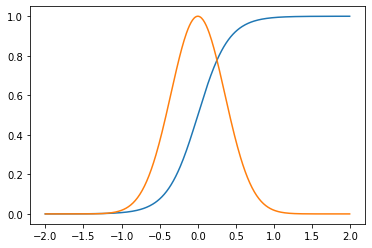

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from pymlutil.functions import Sigmoid, GaussianBasis
x = np.arange(-2.0, 2.0, 0.01) 
y1 = Sigmoid(x, scale = 1.0, offset=0.0, k_exp = 5.0)
plt.plot(x, y1)
y2 = GaussianBasis(torch.tensor(x), sigma=0.5)
plt.plot(x, y2)
plt.show()

6 July 2022
- Removed batch norm layers from UNET
- Training and pruning results were at least as good to network with batch norm
- No clear advantage provided by batch norm for weight magnitude from impacting relaxation magnitude
- crisplit_20220630i0_train
    ```yaml
    cross_entropy_loss: 0.0030129256192594767 
    test: 
        similarity: 
            0: 0.9977446895166078 
            1: 0.8221591634441512 
        average time: 0.003201360332294909 
        miou: 0.9099519264803795 
        num images: 963
    ```
- crisplit_20220630i0_train-fine
    ```yaml
    cross_entropy_loss: 0.002983461134135723 
    architecture_loss: 0.005337885580956936 
    prune_loss: 0.1341208666563034 
    architecture_reduction: 0.05337885394692421 
    test: 
        similarity: 
            0: 0.9975066577436897 
            1: 0.8136417113713045 
        average time: 0.007769013499480788 
        miou: 0.9055741845574972 
        num images: 963
    ```
- crisplit_20220630i0_prune 
    ```yaml
    prune: 
        final parameters: 593296 
        initial parameters: 31037517 
        remaining ratio: 0.019115446638337724 
    training: 
        cross_entropy_loss: 0.0037698952946811914 
    test: 
        similarity: 
            0: 0.9975929543526758 
            1: 0.8155541153342405 
        average time: 0.0032667279335410193 
        miou: 0.9065735348434582 
        num images: 963
    ```
- No full-layer collapse of UNET which may have caused a deviation between full and relaxed network

![crisplit_20220630i0_train-fine_cw.pn](../img/crisplit_20220630i0_train-fine_cw.png)
![crisplit_20220630i0_prune_cw.png](../img/crisplit_20220630i0_prune_cw.png)

- Architecture reduction never became 0
- Possibility of additional pruning while maintaining accuracy
- Prune loss continued to fall but with a falling rate
- Possibility of improved relaxation with increased time in train_fine
- increasing prune_basis did not appear to negatively impact architecture loss or cross_entropy loss
- How sloppy can I be with the prune_basis?  
- Can prune_basis be applied 100% throughout train_fine relaxation? 
- Would this slow architecture search?
- This would eliminate several parameters
- This would provide additional time to converge prune_loss
- When relaxation is removed, the scale factor is not applied to the convolution weights.
- If the convolution weight is 1 or 0, then there is a resulting shift that must be removed in post prune training
- Can post prune training be shortened or removed?
- Investigate changing prune epochs from 15 to 7 or 5
- Investigate converting sigmoid function to a fixed scale multiple

![crisplit_20220630i_tb.png](../img/crisplit_20220630i_tb.png)

### From literature review
- Can I demonstrate a linear reduction in time for structured pruning size reduction?
- This time reduction will need to adjust batch size to benefit from very heavy pruning.
- Can I demonstrate a different time reduction for unstructured pruning?
- Is this independent from other neural network optimizations: NAS, parameter optimization, quantization, target hardware optimization
- Structured pruning may be achieving similar compression ratios and accuracies as unstructured pruning.  
- If so, how?
- Quantify performance advantages of structured pruning
- What differences are there to the Lottery Ticket Hypothesis?
- Is there a more appropriate theoretical basis?
- Is there a theoretical basis independent of an approximation function?
- Are there any useful conclusions that can be made from this?
- Is the final pruning dependent on the initial state as is commonly assumed in the lottery ticket hypothesis
- What are the advantages/disadvantages of relaxation vs magnitude pruning?
- Explore simultaneous training/pruning
- Training/pruning from random variables
- Training/pruning from pretrained network
- Training/pruning from transfer learning
- How to speed pytorch training?  
- It seems much slower than Tensorflow training.  
- This may be due to FCN vs UNET not PyTorch vs Tensorflow or Tensorflow optimized data pipeline vs my Pytorch S3 data pulling.
- How robust is a pruned model in retraining?
- How robust is a pruned model to training in a new domain?
- Does the model converge to an equivalent solution?  
- How to deter


